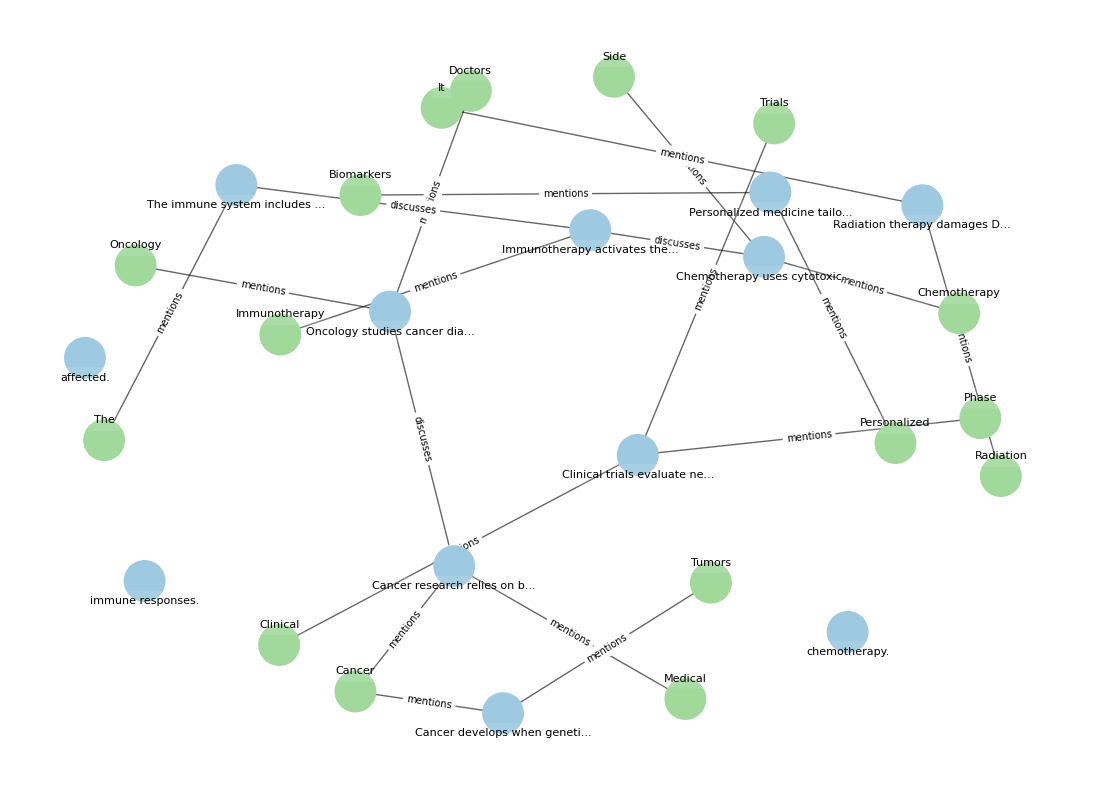

In [10]:
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

corpus = [
    "Cancer develops when genetic mutations cause uncontrolled cell division. Tumors can spread to other organs through metastasis.",
    "Oncology studies cancer diagnosis and treatment. Doctors classify cancer stages to guide therapy decisions.",
    "Chemotherapy uses cytotoxic drugs to kill rapidly dividing cancer cells. Side effects occur because healthy cells are also affected.",
    "Radiation therapy damages DNA in cancer cells using high energy rays. It is often combined with surgery or chemotherapy.",
    "Immunotherapy activates the immune system to target cancer. T cells recognize tumor antigens and destroy malignant cells.",
    "The immune system includes innate and adaptive immunity. T cells and B cells play central roles in adaptive immune responses.",
    "Clinical trials evaluate new cancer therapies in patients. Trials progress through Phase I Phase II and Phase III.",
    "Personalized medicine tailors cancer treatment based on genetic profiles. Biomarkers help predict treatment response.",
    "Cancer research relies on biological datasets and clinical evidence. Medical journals publish peer reviewed oncology studies."
]

def chunk(text, n):
    w = text.split()
    return [" ".join(w[i:i+n]) for i in range(0, len(w), n)]

def entities(text):
    return re.findall(r"\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)\b", text)

def vector(text, vocab):
    v = np.zeros(len(vocab))
    for w in re.findall(r"\w+", text.lower()):
        if w in vocab:
            v[vocab[w]] += 1
    n = np.linalg.norm(v)
    return v / n if n else v

chunks = []
for i, d in enumerate(corpus):
    for j, c in enumerate(chunk(d, 18)):
        chunks.append((f"c{i}_{j}", c))

ents = {}
for _, t in chunks:
    for e in entities(t):
        if e not in ents:
            ents[e] = f"e{len(ents)}"

texts = [t for _, t in chunks] + list(ents.keys())
vocab = {}
for t in texts:
    for w in re.findall(r"\w+", t.lower()):
        if w not in vocab:
            vocab[w] = len(vocab)

vecs = {}
for i, t in chunks:
    vecs[i] = vector(t, vocab)
for e, i in ents.items():
    vecs[i] = vector(e, vocab)

G = nx.Graph()

for i, t in chunks:
    G.add_node(i, kind="chunk", label=t)

for e, i in ents.items():
    G.add_node(i, kind="entity", label=e)

for i, t in chunks:
    for e in entities(t):
        G.add_edge(i, ents[e], relation="mentions")

ids = [i for i, _ in chunks]
for a in range(len(ids)):
    for b in range(a + 1, len(ids)):
        s = np.dot(vecs[ids[a]], vecs[ids[b]])
        if s > 0.28:
            G.add_edge(ids[a], ids[b], relation="discusses")

ent_ids = list(ents.values())
for a in range(len(ent_ids)):
    for b in range(a + 1, len(ent_ids)):
        s = np.dot(vecs[ent_ids[a]], vecs[ent_ids[b]])
        if s > 0.35:
            G.add_edge(ent_ids[a], ent_ids[b], relation="related_to")

pos = nx.spring_layout(G, seed=11, k=1.2)

label_pos = {}
for n, (x, y) in pos.items():
    label_pos[n] = (x, y + (0.06 if G.nodes[n]["kind"] == "entity" else -0.06))

node_colors = ["#9ecae1" if G.nodes[n]["kind"] == "chunk" else "#a1d99b" for n in G.nodes]

node_labels = {}
for n in G.nodes:
    t = G.nodes[n]["label"]
    node_labels[n] = t if len(t) < 30 else t[:27] + "..."

edge_labels = {}
for u, v, d in G.edges(data=True):
    edge_labels[(u, v)] = d["relation"]

plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=850)
nx.draw_networkx_edges(G, pos, alpha=0.6)
nx.draw_networkx_labels(G, label_pos, node_labels, font_size=8, bbox=dict(fc="white", ec="none", alpha=0.10))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.axis("off")
plt.show()



In [11]:
print("Nodes")
for n in G.nodes:
    print(n, G.nodes[n]["kind"], G.nodes[n]["label"])

print("\nEdges")
for u, v, d in G.edges(data=True):
    print(u, "-", v, d["relation"])

Nodes
c0_0 chunk Cancer develops when genetic mutations cause uncontrolled cell division. Tumors can spread to other organs through metastasis.
c1_0 chunk Oncology studies cancer diagnosis and treatment. Doctors classify cancer stages to guide therapy decisions.
c2_0 chunk Chemotherapy uses cytotoxic drugs to kill rapidly dividing cancer cells. Side effects occur because healthy cells are also
c2_1 chunk affected.
c3_0 chunk Radiation therapy damages DNA in cancer cells using high energy rays. It is often combined with surgery or
c3_1 chunk chemotherapy.
c4_0 chunk Immunotherapy activates the immune system to target cancer. T cells recognize tumor antigens and destroy malignant cells.
c5_0 chunk The immune system includes innate and adaptive immunity. T cells and B cells play central roles in adaptive
c5_1 chunk immune responses.
c6_0 chunk Clinical trials evaluate new cancer therapies in patients. Trials progress through Phase I Phase II and Phase III.
c7_0 chunk Personalized medicine

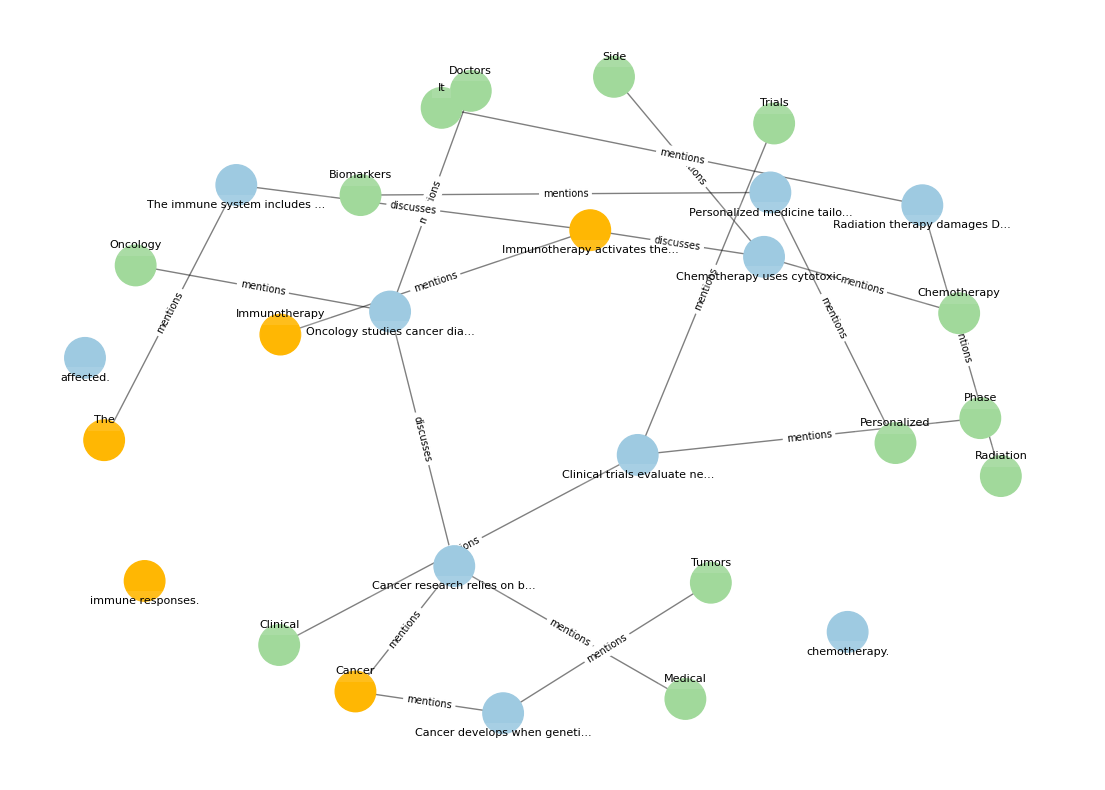

Query: How does immunotherapy treat cancer using the immune system

Retrieved Nodes
c4_0 chunk Immunotherapy activates the immune system to target cancer. T cells recognize tumor antigens and destroy malignant cells.
e0 entity Cancer
e8 entity Immunotherapy
e9 entity The
c5_1 chunk immune responses.


In [14]:
query = "How does immunotherapy treat cancer using the immune system"

q_vec = vector(query, vocab)

scores = []
for n in G.nodes:
    if n in vecs:
        s = float(np.dot(q_vec, vecs[n]))
        scores.append((n, s))

scores.sort(key=lambda x: x[1], reverse=True)

top_k = 5
retrieved = [n for n, _ in scores[:top_k]]

retrieved_colors = []
for n in G.nodes:
    if n in retrieved:
        retrieved_colors.append("#ffb703")
    else:
        retrieved_colors.append("#9ecae1" if G.nodes[n]["kind"] == "chunk" else "#a1d99b")

plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, node_color=retrieved_colors, node_size=850)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, label_pos, node_labels, font_size=8, bbox=dict(fc="white", ec="none", alpha=0.10))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.axis("off")
plt.show()

print("Query:", query)
print("\nRetrieved Nodes")
for n in retrieved:
    print(n, G.nodes[n]["kind"], G.nodes[n]["label"])


/tmp/ipython-input-2392941848.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")


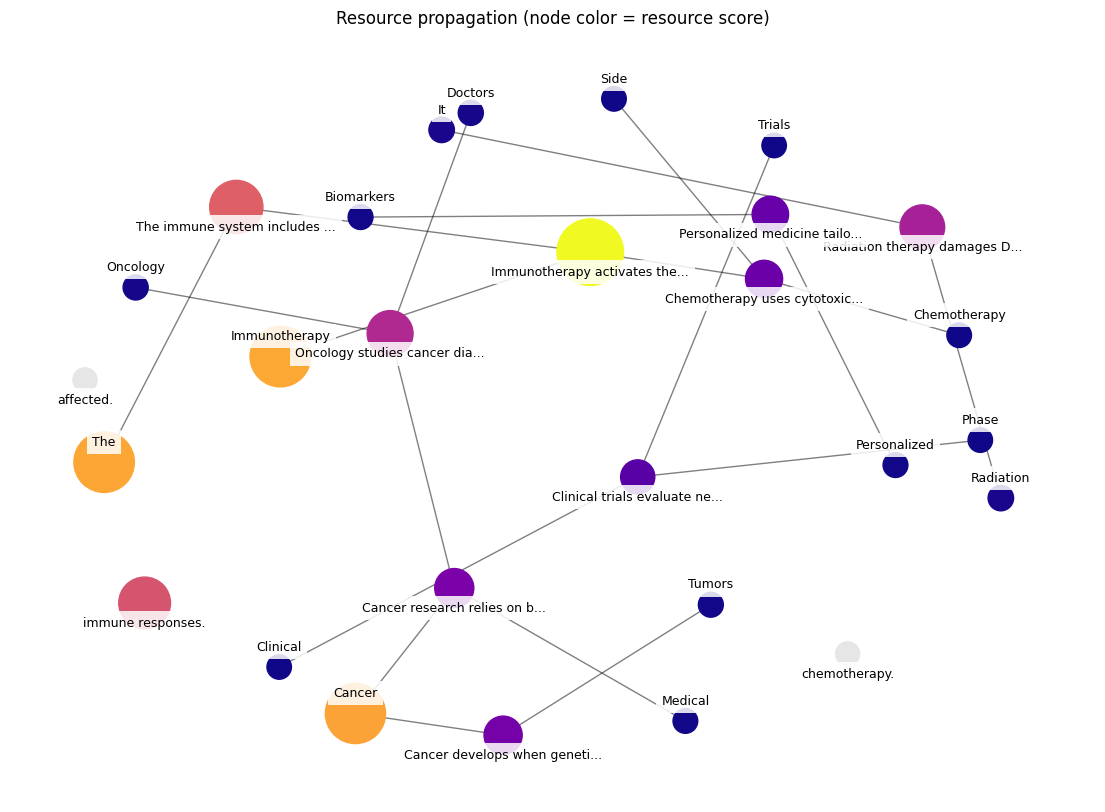

Top retrieved+propagated nodes
c4_0 chunk 0.1537 - Immunotherapy activates the immune system to target cancer. T cells recognize tumor antigens and destroy malignant cells.
e8 entity 0.1235 - Immunotherapy
e9 entity 0.1229 - The
e0 entity 0.1214 - Cancer
c5_0 chunk 0.0899 - The immune system includes innate and adaptive immunity. T cells and B cells play central roles in adaptive
c5_1 chunk 0.0837 - immune responses.
c1_0 chunk 0.0609 - Oncology studies cancer diagnosis and treatment. Doctors classify cancer stages to guide therapy decisions.
c3_0 chunk 0.0564 - Radiation therapy damages DNA in cancer cells using high energy rays. It is often combined with surgery or

Pruned nodes (resource < theta)
c0_0 0.03497
c2_0 0.03182
c2_1 0.00000
c3_1 0.00000
c6_0 0.02346
c7_0 0.02990
c8_0 0.03783
e1 0.00175
e2 0.00203
e3 0.00203
e4 0.00106
e5 0.00106
e6 0.00282
e7 0.00282
e10 0.00078
e11 0.00078
e12 0.00078
e13 0.00150
e14 0.00150
e15 0.00126

Top paths
score 0.1386 : Immunotherapy activates t

In [16]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

alpha = 0.10
theta = 0.04
max_iter = 200
tol = 1e-6
top_k_paths = 8
max_path_len = 4

p_scores = {}
for n in G.nodes:
    if n in vecs:
        p_scores[n] = float(np.dot(q_vec, vecs[n]))
if not p_scores:
    p = np.ones(len(G)) / len(G)
else:
    vals = np.array(list(p_scores.values()))
    vals = np.clip(vals, a_min=0, a_max=None)
    if vals.sum() == 0:
        p = np.ones(len(vals)) / len(vals)
    else:
        p = vals / vals.sum()
    nodes_list = list(p_scores.keys())
    index = {n:i for i,n in enumerate(nodes_list)}
    n_nodes = len(nodes_list)
    A = np.zeros((n_nodes, n_nodes))
    for u,v,d in G.subgraph(nodes_list).edges(data=True):
        i = index[u]
        j = index[v]
        w = d.get("weight", 1.0)
        A[i,j] = w
        A[j,i] = w
    row_sums = A.sum(axis=1)
    M = np.zeros_like(A)
    nz = row_sums > 0
    M[nz] = A[nz] / row_sums[nz,None]
    r = p.copy()
    for _ in range(max_iter):
        r_new = (1-alpha) * p + alpha * (M.T @ r)
        if np.linalg.norm(r_new - r, 1) < tol:
            r = r_new
            break
        r = r_new
    resources = {nodes_list[i]: float(r[i]) for i in range(n_nodes)}

all_nodes = list(G.nodes)
res_vec = np.array([resources.get(n, 0.0) for n in all_nodes])
if res_vec.max() > 0:
    norm = (res_vec - res_vec.min()) / (res_vec.max() - res_vec.min() + 1e-12)
else:
    norm = res_vec

cmap = cm.get_cmap("plasma")
node_colors = [cmap(v) if v>0 else (0.9,0.9,0.9,1.0) for v in norm]
node_sizes = [300 + 2000*v for v in norm]

pruned = [n for n,v in resources.items() if v < theta]
kept = [n for n in all_nodes if n not in pruned]

plt.figure(figsize=(14,10))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, alpha=0.5)
label_dict = {n: node_labels.get(n,n) for n in G.nodes}
nx.draw_networkx_labels(G, label_pos, label_dict, font_size=9, bbox=dict(fc="white", ec="none", alpha=0.85))
plt.title("Resource propagation (node color = resource score)")
plt.axis("off")
plt.show()

ranked = sorted(resources.items(), key=lambda x: x[1], reverse=True)
print("Top retrieved+propagated nodes")
for n, s in ranked[:8]:
    kind = G.nodes[n]["kind"]
    label = G.nodes[n]["label"]
    print(n, kind, f"{s:.4f}", "-", label)

print("\nPruned nodes (resource < theta)")
for n in pruned:
    print(n, f"{resources.get(n,0.0):.5f}")

paths = []
high_nodes = [n for n,s in ranked if s>0]
for i in range(len(high_nodes)):
    for j in range(i+1, len(high_nodes)):
        a = high_nodes[i]
        b = high_nodes[j]
        try:
            for path in nx.all_simple_paths(G, source=a, target=b, cutoff=max_path_len):
                score = np.mean([resources.get(x,0.0) for x in path])
                paths.append((path, score))
        except nx.NetworkXNoPath:
            pass
paths = sorted(paths, key=lambda x: x[1], reverse=True)[:top_k_paths]
print("\nTop paths")
for path, score in paths:
    readable = []
    for k in range(len(path)-1):
        u = path[k]
        v = path[k+1]
        rel = G.edges[u,v].get("relation", G.edges[u,v].get("kind","link"))
        readable.append(f"{G.nodes[u]['label']} -[{rel}]->")
    readable.append(G.nodes[path[-1]]["label"])
    print(f"score {score:.4f} :", " ".join(readable))


In [17]:
top_k_paths = 5
max_path_len = 4

candidate_nodes = [n for n, v in resources.items() if v >= theta]

paths = []
for i in range(len(candidate_nodes)):
    for j in range(i + 1, len(candidate_nodes)):
        u = candidate_nodes[i]
        v = candidate_nodes[j]
        try:
            for p in nx.all_simple_paths(G, u, v, cutoff=max_path_len):
                score = np.mean([resources.get(x, 0.0) for x in p])
                paths.append((p, score))
        except:
            pass

paths = sorted(paths, key=lambda x: x[1], reverse=True)[:top_k_paths]

print("Top Scored Paths")
for p, s in paths:
    readable = []
    for k in range(len(p) - 1):
        rel = G.edges[p[k], p[k+1]]["relation"]
        readable.append(f"{G.nodes[p[k]]['label']} -[{rel}]->")
    readable.append(G.nodes[p[-1]]["label"])
    print(f"{s:.4f} :", " ".join(readable))


Top Scored Paths
0.1386 : Immunotherapy activates the immune system to target cancer. T cells recognize tumor antigens and destroy malignant cells. -[mentions]-> Immunotherapy
0.1225 : Immunotherapy -[mentions]-> Immunotherapy activates the immune system to target cancer. T cells recognize tumor antigens and destroy malignant cells. -[discusses]-> The immune system includes innate and adaptive immunity. T cells and B cells play central roles in adaptive -[mentions]-> The
0.1224 : The immune system includes innate and adaptive immunity. T cells and B cells play central roles in adaptive -[discusses]-> Immunotherapy activates the immune system to target cancer. T cells recognize tumor antigens and destroy malignant cells. -[mentions]-> Immunotherapy
0.1222 : Immunotherapy activates the immune system to target cancer. T cells recognize tumor antigens and destroy malignant cells. -[discusses]-> The immune system includes innate and adaptive immunity. T cells and B cells play central roles 

In [18]:
prompt_paths = []
for p, s in reversed(paths):
    text = []
    for k in range(len(p) - 1):
        rel = G.edges[p[k], p[k+1]]["relation"]
        text.append(f"{G.nodes[p[k]]['label']} {rel} {G.nodes[p[k+1]]['label']}")
    prompt_paths.append(" ; ".join(text))

query_text = "How does immunotherapy treat cancer using the immune system?"

prompt = "Question:\n" + query_text + "\n\nRelevant knowledge:\n"
for i, t in enumerate(prompt_paths):
    prompt += f"- {t}\n"

prompt += "\nAnswer:"

print("\nFinal Prompt\n")
print(prompt)



Final Prompt

Question:
How does immunotherapy treat cancer using the immune system?

Relevant knowledge:
- Immunotherapy activates the immune system to target cancer. T cells recognize tumor antigens and destroy malignant cells. discusses The immune system includes innate and adaptive immunity. T cells and B cells play central roles in adaptive
- Immunotherapy activates the immune system to target cancer. T cells recognize tumor antigens and destroy malignant cells. discusses The immune system includes innate and adaptive immunity. T cells and B cells play central roles in adaptive ; The immune system includes innate and adaptive immunity. T cells and B cells play central roles in adaptive mentions The
- The immune system includes innate and adaptive immunity. T cells and B cells play central roles in adaptive discusses Immunotherapy activates the immune system to target cancer. T cells recognize tumor antigens and destroy malignant cells. ; Immunotherapy activates the immune system 